# Link Prediction Toy Problem - Neo4J & SciKit-Learn

This notebook is a scratch space to reimplement the graph based machine learning toy problem from **Graph Algorithms** chapter 8. This excercise demonstrations how to use graph data to improve machine learning algorithms, and how to connect a graph database (Neo4J) with Python's machine learning libraries (Scikit-Learn).

## Background

### Feature extraction: 
*Feature extraction* is how we distill large volumes of data and attributes down into a set that is representative and tractable. We derive numerical features to represent characteristics or patterns in the graph. Feature extraction is used when the data is difficult to model directly due to size, format, etc.

Graph algorithms can be used for *connected* feature extraction:
-  *graph embeddings* represent nodes and relationships as feature vectors. They allow us to represent graphs (or subgraphs) in a numerical format ready for ML tasks. Useful for unsupervised ML algorithms, data exploration, dimensionality reduction, 
-  *graphy features* are connection related metrics about the graph. 
    -  number of relationships coming in and out of nodes
    -  count of potential triangles
    -  common neighbors
    -  feature engineering: if we know something is interesting or relevant, we can create that feature or attribute in the graph. You can use graph traversal to find specific paths, look at labels, attributes, counts, and inferred relationships. For example, something being 4 hops away might be indicative of something, so a count of nodes 4 hops away can be added as a node attribute.
-  *graph algorithm features* these are features that describe the general graph structure, but not the exact pattern.
    -  community detection algorithms (eg Louvain) 
    -  centrality algorithms (PageRank)

### Feature selection:
*Feature selection* is choosing the right subset of extracted features that are important or influential in predicting the target goal.  It's important to eliminate unnecessary features to limit over fitting.

We can use graph algorithms to evaluate *connected features* to evaluate their importance for feature selection - eg. PageRank to prioritize features with the most influence. We can also identify features with high co-occurence for model tuning via feature reduction.

## Link Prediction
*Link prediction* is a way of estimating how likely a relationship is to form in the future, or whether is should already be in the graph but is missing due to incomplete data. This is valuable because networks are dynamic and can grow fairly quickly, and can be used for product recommendations, drug targeting, and predicting social relationships.

Connected features from graphs are often used for link predictions using:
-  graphy features (node proximity)
-  centrality and community detection algorithms

## Setting up the co-authorship graph

In order to build the ML classifier algorithms, we need to start from a graph. For this example, we'll be using the citation network dataset published by Tang et al. for *ArnetMiner* and available at aminer.org

### configuration and set up
These steps get you the raw data, and reconfigures your database to use the necessary libraries.
-  Download the citation dataset: https://aminer.org/citation
-  Create a new (empty) graph in Neo4J desktop
-  Update the graph settings: go to your project, add a graph (mine is called CoAuthorGraph) and select "manage" from the menu
    -  enable graph algorithms by selecting install and restart
    -  enable APOC by going to plugins, installing APIC, and adding it to your project
    -  enable APOC data imports by going to settings and pasting the following two lines at the end of the file: 
    
    `apoc.import.file.enabled=true`
    
    `apoc.import.file.use_neo4j_config=true`
    
-  Add your downloaded files to the import directory: in Neo4J desktop, in your active database, select "open folder" and choose import. Extract the four json files from the aminer download to this directory.

### queries to load the data via apoc

Launch the Neo4J browser and use the Cypher query window to run these steps.

Set database constraints to force authors and papers to be unique

```
CREATE CONSTRAINT ON (article:Article)
ASSERT article.index IS UNIQUE;

CREATE CONSTRAINT ON (author:Author)
ASSERT author.name IS UNIQUE;
```
Load the data in directly via APOC:
```
CALL apoc.periodic.iterate(
  'UNWIND ["dblp-ref-0.json","dblp-ref-1.json","dblp-ref-2.json","dblp-ref-3.json"] AS file
   CALL apoc.load.json("file:///" + file)
   YIELD value
   WHERE value.venue IN ["Lecture Notes in Computer Science", "Communications of The ACM",
                         "international conference on software engineering",
                         "advances in computing and communications"]
   return value',
  'MERGE (a:Article {index:value.id})
   ON CREATE SET a += apoc.map.clean(value,["id","authors","references"],[0])
   WITH a,value.authors as authors
   UNWIND authors as author
   MERGE (b:Author{name:author})
   MERGE (b)<-[:AUTHOR]-(a)'
, {batchSize: 10000, iterateList: true});
```

All work after this will be done via Python & Py2Neo try to keep the queries and code in a single document.

### Import necessary libraries

In [383]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### Setup the Graph Connector

In [452]:
from py2neo import Graph
ngViVMO_lS27Lg5WNFG0yRtBlnEr-Ty73ApIve2t4fQ
uri = 'bolt://localhost:7687'
coauthorGraph=Graph(uri, auth=("neo4j","password"))

### Create a co-author relationship
the first thing this query does is find all the papers with multiple authors (with MATCH) and sorts the results on the year of the paper publication.
WITH takes all author pairs and their shared papers, and COLLECTS the first year where two authors shared a paperto create the "year" variable and calculates the COUNT of papers per author pair is the collaborations variable

MERGE makes a new relationship called CO_AUTHOR between the author pairs, and assigns the year and collaborations variables as properties. 

In [29]:
query='''
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year as year, count(*) as collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations=collaborations;
'''

In [18]:
#run the query on the graph
coauthorGraph.run(query);

## Creating balanced training and testing sets
The ultimate goal in this example is to predict future coauthor relationships, so in order to evaluate our model, we need to start with a train/test split that evaluates our ability to predict the future - meaning the data should be split on year of publication.

In [454]:
# evaluate when the articles in the dataset were published
query='''
MATCH (a:Article)
RETURN a.year as year, count(*) as total_pubs
ORDER BY year
'''
years = coauthorGraph.run(query).data() #to_data_frame() doesn't work
years = pd.DataFrame(years)

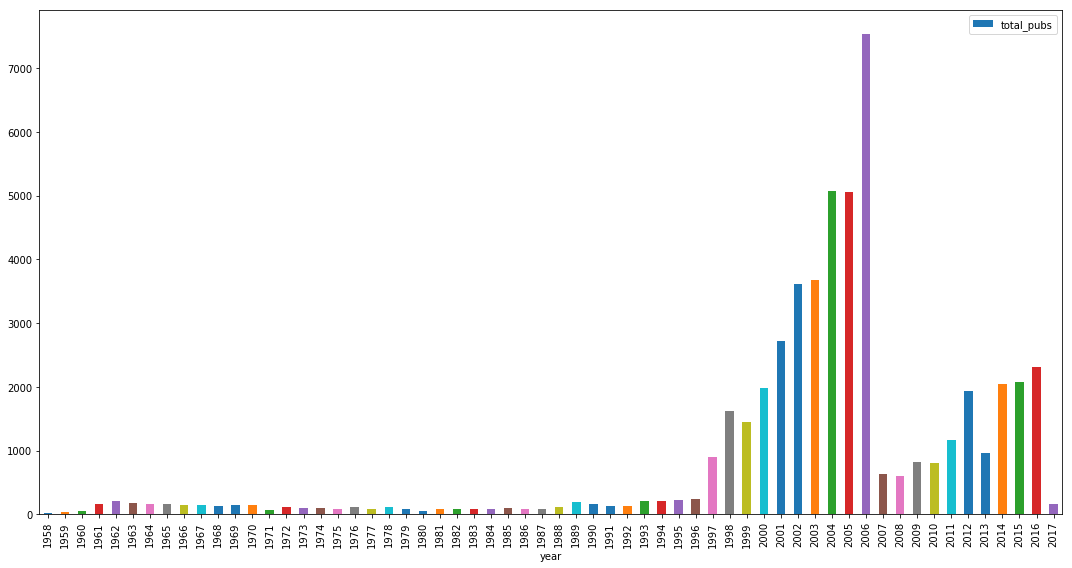

In [37]:
years.plot(kind='bar', x='year', y='total_pubs',figsize=(15,8))
plt.tight_layout()

Visually, we can split the data around 2006 to get a reasonable 60/40 split. We can also evaluate this by making the calculation in pandas...

In [53]:
years['pubs_to_date']=years['total_pubs'].cumsum()
total_pubs=years['total_pubs'].sum()
years['pct_pubs_to_date']=years['pubs_to_date']/total_pubs
years[years['pct_pubs_to_date'].gt(.6)].iloc[[0]]

,total_pubs,year,pubs_to_date,pct_pubs_to_date
48,7536,2006,38433,0.739722


Now, we need to create the split in the graph - this can be used for calculating our graphy features and graph algorithm features, and allows us to split the graph itself into test and train. We can use the same co-author query (that created the co-author relationship) as before, but just restrict it based on year of publication.

In [54]:
# "early" coauthors
query='''
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year as year, count(*) as collaborations
WHERE year < 2006
MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
SET coauthor.collaborations=collaborations;
'''
coauthorGraph.run(query);

In [55]:
# "late" coauthors
query='''
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year as year, count(*) as collaborations
WHERE year >= 2006
MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
SET coauthor.collaborations=collaborations;
'''
coauthorGraph.run(query);

In [56]:
# evaluate the results
# "early" coauthors
query='''
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) as count
'''
num_early = coauthorGraph.run(query).data()
print("count train co-authors: ",num_early)

query='''
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) as count
'''
num_late = coauthorGraph.run(query).data()
print("count test co-authors: ", num_late)

count train co-authors:  [{'count': 81096}]
count test co-authors:  [{'count': 74128}]


### balancing the data - negative examples
In most real world networks, the numer of examples of pairs of entities that do not have a relationship is far greater than the number that do. In this graph we have 45,018 authors - so there are potentially over a billion relationships, but only 81k are true - meaning that 99.9% of authors don't have relationships. If we use the raw data, we would have a severe class imbalance - we could always predict there's no relationship and have very high accuracy.

To fix this, we need to identify the negative relationships (find pairs of nodes between 2 and 3 hops apart) and downsample those so we have equal numbers of positive and negative edges.

**Note** - *we are also going to use Cypher queries to create the training data directly here*, by returning node ids and 0/1 (true, false) values which can be used by ML algorithms

In [62]:
# start by finding the negative edges - nodes (pairs of authors) who have no relationship at a distance of 2 or 3 hops out
query='''
MATCH(author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE NOT ((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) as node1, id(other) as node2, 0 as label
''' # note '0 as label' indicates no link
training_no_link = coauthorGraph.run(query).data()
training_no_link=pd.DataFrame(training_no_link)
len(training_no_link)

4389478

In [71]:
# and now a query for the positive edges (this one runs much faster)
query='''
MATCH(author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) as node1, id(other) as node2, 1 as label
''' 
training_existing_links = coauthorGraph.run(query).data()
training_existing_links=pd.DataFrame(training_existing_links)
len(training_existing_links)

81096

In [72]:
#clean up the data - drop duplicates
training_no_link=training_no_link.drop_duplicates()
training_existing_links=training_existing_links.drop_duplicates()

In [68]:
# now we need to downsample the majority class - I'm just going to use SKLearn's resample function
training_no_link_downsampled=resample(training_no_link,replace=False,n_samples=len(training_existing_links),random_state=42)

In [80]:
# merge the data back together to create the training dataset
training_df=training_existing_links.append(training_no_link_downsampled)

In [84]:
#now we do the same to make a test dataframe
#negative edges
query='''
MATCH(author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE NOT ((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) as node1, id(other) as node2, 0 as label
''' 
testing_no_link = coauthorGraph.run(query).data()
testing_no_link=pd.DataFrame(testing_no_link)

# and now a query for the positive edges (this one runs much faster)
query='''
MATCH(author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) as node1, id(other) as node2, 1 as label
''' 
testing_existing_links = coauthorGraph.run(query).data()
testing_existing_links=pd.DataFrame(testing_existing_links)

#drop duplicates
testing_no_link=testing_no_link.drop_duplicates()
testing_existing_links=testing_existing_links.drop_duplicates()

#resample
testing_no_link_downsampled=resample(testing_no_link,replace=False,n_samples=len(testing_existing_links),random_state=42)

# merge the data back together to create the testing dataset
testing_df=testing_existing_links.append(testing_no_link_downsampled)

In [85]:
#check the outputs:
training_df.groupby(['label']).count()

,node1,node2
label,,
0,81096,81096
1,81096,81096


In [86]:
#check the outputs:
testing_df.groupby(['label']).count()

,node1,node2
label,,
0,74128,74128
1,74128,74128


## Feature extraction to predict missing links
We need to start with some basic hypotheses about what features might be relevant to identify missing links. For co-authorship, it's likely to be metrics around communities including:
-  more coauthors in common
-  triadic relationships between coauthors (if two nodes are connected via a third node, it's likely that those two would become directly connected in the future)
-  authors with more relationships
-  authors in the same communities (eg real time systems)
-  authors in the same tighter subcommunities (eg an institute at a university)

### Start from basic graphy features:
-  common authors: the number of potential triangles between two authors
-  preferential attachment: multiplies the number of coauthors each author in a pair has - the score reflects that authors are more likely to collaborate with authors who have lots of collaborators
-  total union of neighbors: fund the total number of coauthors each author has minus duplicates

In [289]:
def apply_graphy_training_features(data):
    query='''
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
        pair.node2 as node2,
        size([(p1)-[:CO_AUTHOR_EARLY]-(a)-[:CO_AUTHOR_EARLY]-(p2)|a]) AS commonAuthors,
        size ((p1)-[:CO_AUTHOR_EARLY]-()) * size((p2)-[:CO_AUTHOR_EARLY]-()) AS prefAttachment,
        size(apoc.coll.toSet([
            (p1)-[:CO_AUTHOR_EARLY]->(a) | id(a)] + [(p2)-[:CO_AUTHOR_EARLY]->(a) | id(a)
           ])) AS totalNeighbours
    '''
    # you have to recast the node IDs as ints bc of a collision with numpy int64
    pairs = [{"node1":int(row["node1"]), "node2": int(row["node2"])} for index, row in data.iterrows()]    
    result = coauthorGraph.run(query, {"pairs":pairs}).data()
    result = pd.DataFrame(result)
    merged_result = pd.merge(data, result, on=['node1','node2'])
    return merged_result

In [290]:
# and do the same for the test data
def apply_graphy_test_features(data):
    query='''
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
        pair.node2 as node2,
        size([(p1)-[:CO_AUTHOR_LATE]-(a)-[:CO_AUTHOR_LATE]-(p2)|a]) AS commonAuthors,
        size ((p1)-[:CO_AUTHOR_LATE]-()) * size((p2)-[:CO_AUTHOR_LATE]-()) AS prefAttachment,
        size(apoc.coll.toSet([
            (p1)-[:CO_AUTHOR_LATE]->(a) | id(a)] + [(p2)-[:CO_AUTHOR_LATE]->(a) | id(a)
           ])) AS totalNeighbours
    '''
    # you have to recast the node IDs as ints bc of a collision with numpy int64
    pairs = [{"node1":int(row["node1"]), "node2": int(row["node2"])} for index, row in data.iterrows()]    
    result = coauthorGraph.run(query, {"pairs":pairs}).data()
    result = pd.DataFrame(result)
    merged_result = pd.merge(data, result, on=['node1','node2'])
    return merged_result

In [291]:
# add the graph features to the test/train vectors
training_df=apply_graphy_training_features(training_df)

In [293]:
testing_df=apply_graphy_test_features(testing_df)

In [282]:
# DONT RUN THIS - THIS IS ONLY HERE IN CASE I OVER WRITE THE TEST TRAIN DATA
# training_df=training_existing_links.append(training_no_link_downsampled)
# testing_df=testing_existing_links.append(testing_no_link_downsampled)

In [319]:
# examine the graphy features
commonAuthor_linked=training_df[training_df['label']==1]['commonAuthors'].value_counts(normalize=True).sort_index()
commonAuthor_unlinked=training_df[training_df['label']==0]['commonAuthors'].value_counts(normalize=True).sort_index()

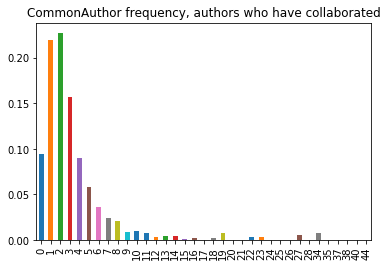

In [327]:
commonAuthor_linked.plot(kind='bar', title='CommonAuthor frequency, authors who have collaborated')


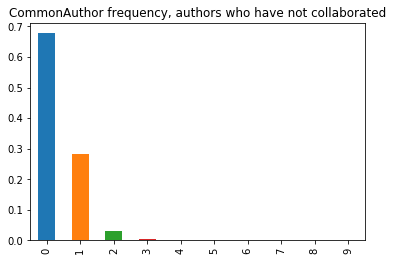

In [328]:
commonAuthor_unlinked.plot(kind='bar', title='CommonAuthor frequency, authors who have not collaborated')

## Train some models!
Let's start training basic models - beginning with just the commonAuthors feature

In [423]:
# random forest classifier - set up the model inputs and targets
# have to reshape the arrays to work with sklearn
x_train=training_df['commonAuthors'].values.reshape(-1,1)
x_test=testing_df['commonAuthors'].values.reshape(-1,1)
y_train=training_df['label'].values.reshape(-1,1)
y_test=testing_df['label'].values.reshape(-1,1)

rf_classifier=RandomForestClassifier(random_state=42)
# use np.ravel to swap the labels from column to row format
rf_classifier.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's test out some dummy predictions with the newly trained model

In [424]:
test_predict=np.array([0,1,2,10,100]).reshape(-1,1)
rf_classifier.predict_proba(test_predict)

array([[0.8783921 , 0.1216079 ],
       [0.56474941, 0.43525059],
       [0.11817702, 0.88182298],
       [0.        , 1.        ],
       [0.        , 1.        ]])

How do I even interpret this? The two columns correspond to the probability that the input values (0, 1, 2, 10, and 100 commonAuthors in the graph) have a relationship between two authors. 
-  0 commonAuthors between a pair: 87% chance they are not linked
-  1 commonAuthor: 56% chance they are linked
-  2 commonAuthors: 88% chance they are linked
-  10 (or 100) commonAuthors: 100% chance they're linked

Next, let's evaluate things a bit more systematically using our testing data.

In [425]:
y_preds=rf_classifier.predict(x_test)
confusion_matrix(y_test,y_preds)

array([[71477,  2651],
       [21041, 53087]], dtype=int64)

In [379]:
precision_score(y_test,y_preds)

0.9524381929742725

In [381]:
recall_score(y_test,y_preds)

0.716153140513706

In [384]:
accuracy_score(y_test, y_preds)

0.840195337794086

The simple model built with only a single predictive feature (commonAuthors) performs reasonably well. 
-  *accuracy* - (true positives + true negatives) / total predictions = 84%
-  *precision* - (true positives)/(true positives + false positives) = 95%
-  *recall / true positive rate* - (true positives)/(true positives + false negatives) =71%
- *false positive rate* - (false positives)/(false positives + true negatives) = 3.5%

We can also visualize the performance of the model using a ROC curve

In [386]:
roc_auc_score(y_test, y_preds)

0.8401953377940858

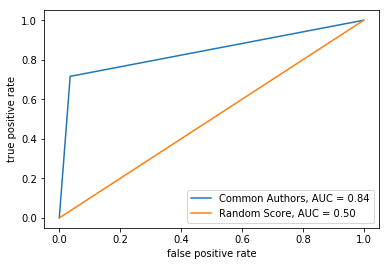

In [388]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.close()
plt.plot(fpr, tpr, label='Common Authors, AUC = 0.84')
plt.plot([0,1],[0,1], label='Random Score, AUC = 0.50')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="bottom right")
plt.show()

What about adding other features? We also calculated preferentialAttachment (nodes with lots of connections tend to make more connections) and totalNeighbors (how many neighbors does each pair have). Let's check the descriptive stats for each:

In [394]:
# statistics for connected authors
training_df[training_df['label']==1][['prefAttachment','totalNeighbours']].describe()

,prefAttachment,totalNeighbours
count,81096.000000,81096.000000
mean,69.935373,6.800570
std,171.470923,7.186484
min,1.000000,1.000000
25%,9.000000,2.000000
50%,24.000000,4.000000
75%,54.000000,8.000000
max,3150.000000,85.000000


In [395]:
# statistics for disconnected authors
training_df[training_df['label']==0][['prefAttachment','totalNeighbours']].describe()

,prefAttachment,totalNeighbours
count,81096.000000,81096.000000
mean,48.066896,7.263909
std,95.320792,8.211897
min,1.000000,0.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,48.000000,10.000000
max,1886.000000,83.000000


Visually inspecting these, it looks like preferentialAttachment has far more variability  between linked and unlinked authors, as compared to totalNeighbors - this suggests that it's a more important variable.

Either way, let's build a new model with all three graph features: commonAuthors, prefAttachment, and totalNeighbors.

In [428]:
# random forest classifier - set up the model inputs and targets
# have to reshape the arrays to work with sklearn
#x_train=training_df['commonAuthors'].values.reshape(-1,1)
x_train=training_df[['commonAuthors','prefAttachment','totalNeighbours']]
x_test3=testing_df[['commonAuthors','prefAttachment','totalNeighbours']]
y_train=training_df['label'].values.reshape(-1,1)
y_test=testing_df['label'].values.reshape(-1,1)

rf3_classifier=RandomForestClassifier(random_state=42)
# use np.ravel to swap the labels from column to row format
rf3_classifier.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [429]:
y_preds3=rf3_classifier.predict(x_test3)
print("accuracy:", accuracy_score(y_test,y_preds3))
print("recall:", recall_score(y_test,y_preds3))
print("precision:", precision_score(y_test,y_preds3))
print("AUC:", roc_auc_score(y_test, y_preds3))

accuracy: 0.9201179041657673
recall: 0.9040848262464926
precision: 0.9340357625677691
AUC: 0.9201179041657674


With the addition of preferential attachment and total neighbors, the accuracy and recall have both increased, although precision has dropped slightly. 

We can also add the ROC curve for this model to our plot for comparison.

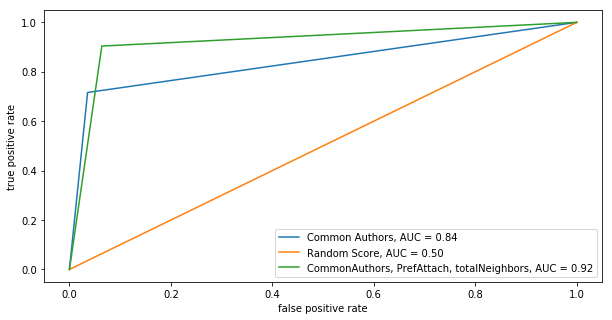

<Figure size 14400x1440 with 0 Axes>

In [436]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_preds3)
plt.close()
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Common Authors, AUC = 0.84')
plt.plot([0,1],[0,1], label='Random Score, AUC = 0.50')
plt.plot(fpr3, tpr3, label='CommonAuthors, PrefAttach, totalNeighbors, AUC = 0.92')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="bottom right")
plt.figure(figsize=(200,20))
plt.show()

In [441]:
# extract feature importance
feature_importance = pd.DataFrame(rf3_classifier.feature_importances_, index=x_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importance

,importance
commonAuthors,0.684087
prefAttachment,0.205997
totalNeighbours,0.109915


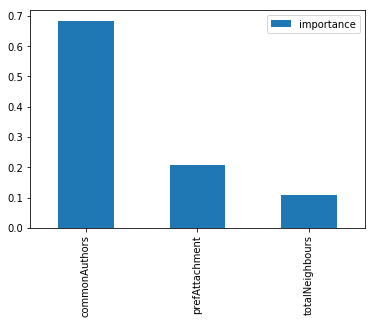

In [443]:
feature_importance.plot(kind='bar')

Common authors is the most important feature by a large margin, followed by preferential attachment and total neighbors. This makes sense in the context of our models: the commonAuthors model, alone, performed quite well, while adding extra features only provided small improvements.

## Add more features to predict links: triangles and clustering coefficients

*Triangle counting* is a community detection algorithm used to determine the number of triangles passing through each node in a graph; a triangle is a set of three nodes where each node is connected to all other nodes. It's often used to detect communities, determine the stability of a graph, or as part of calculating other network indices like clustering coefficients.

*Clustering coefficient* is the measure of the degree to which nodes in the graph are clustered together. Global clustering coefficientes describe the overall clustering of the netwrok, while local gives an indication of the embeddedness of individual nodes.

We can add both of these metrics directly to the graph by calling the Neo4J algorithms library and adding attributes to the nodes in the graph.

In [458]:
#run the query on the graph - add triangles and clustering coefficients to the early edges
query='''
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
  writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
'''
coauthorGraph.run(query);

In [459]:
#add triangles and clustering coefficients to the late edges
query='''
CALL algo.triangleCount('Author', 'CO_AUTHOR_LATE', { write:true,
  writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});'''
coauthorGraph.run(query);

In [465]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query='''
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
           apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
           apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
           apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient

    '''
    # you have to recast the node IDs as ints bc of a collision with numpy int64
    params = {
        "pairs" : [{"node1":int(row["node1"]), "node2": int(row["node2"])} for index, row in data.iterrows()],    
        "trianglesProp": triangles_prop,
        "coefficientProp": coefficient_prop
    }
    result = coauthorGraph.run(query,params).data()
    result = pd.DataFrame(result)
    merged_result = pd.merge(data, result, on=['node1','node2'])
    return merged_result

In [469]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
testing_df = apply_triangles_features(testing_df, "trianglesTest", "coefficientTest")

We can calculate some quick summary statistics for these features as well:

In [472]:
# statistics for connected authors
training_df[training_df['label']==1][['minTriangles','maxTriangles', 'minCoefficient','maxCoefficient']].describe()

,minTriangles,maxTriangles,minCoefficient,maxCoefficient
count,81096.000000,81096.000000,81096.000000,81096.000000
mean,19.478260,27.735906,0.570377,0.845379
std,65.761528,74.018962,0.361461,0.293968
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,0.266667,0.833333
50%,3.000000,8.000000,0.500000,1.000000
75%,10.000000,21.000000,1.000000,1.000000
max,622.000000,785.000000,1.000000,1.000000


In [473]:
#unconnected (no-coauthorship) pairs
training_df[training_df['label']==0][['minTriangles','maxTriangles', 'minCoefficient','maxCoefficient']].describe()

,minTriangles,maxTriangles,minCoefficient,maxCoefficient
count,81096.000000,81096.000000,81096.000000,81096.000000
mean,5.707988,35.184485,0.489277,0.860681
std,20.609580,84.765160,0.368551,0.257112
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,0.180952,0.820513
50%,3.000000,10.000000,0.400000,1.000000
75%,6.000000,28.000000,1.000000,1.000000
max,601.000000,785.000000,1.000000,1.000000


There aren't huge differences between co-author vs. no-coathor pairs, but why not add these into the model as well?

In [475]:
# random forest classifier - set up the model inputs and targets
# have to reshape the arrays to work with sklearn
#x_train=training_df['commonAuthors'].values.reshape(-1,1)
x_train=training_df[["commonAuthors", "prefAttachment", "totalNeighbours", "minTriangles", "maxTriangles",
          "minCoefficient", "maxCoefficient"]]
x_test7=testing_df[["commonAuthors", "prefAttachment", "totalNeighbours", "minTriangles", "maxTriangles",
          "minCoefficient", "maxCoefficient"]]
y_train=training_df['label'].values.reshape(-1,1)
y_test=testing_df['label'].values.reshape(-1,1)

rf7_classifier=RandomForestClassifier(random_state=42)
# use np.ravel to swap the labels from column to row format
rf7_classifier.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [476]:
y_preds7=rf7_classifier.predict(x_test7)
print("accuracy:", accuracy_score(y_test,y_preds7))
print("recall:", recall_score(y_test,y_preds7))
print("precision:", precision_score(y_test,y_preds7))
print("AUC:", roc_auc_score(y_test, y_preds7))

accuracy: 0.9570270343190157
recall: 0.9571417008417872
precision: 0.9569222469485468
AUC: 0.9570270343190158


Again, with some more variables, we've made the model a little bit better.

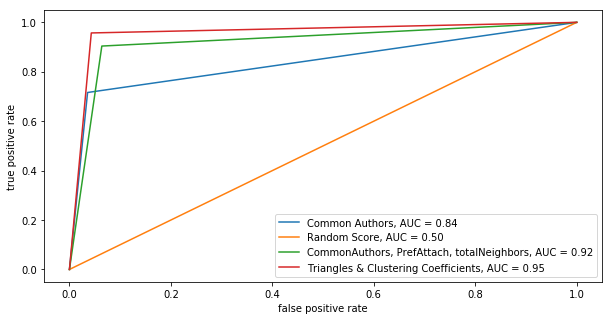

<Figure size 14400x1440 with 0 Axes>

In [477]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_preds3)
fpr7, tpr7, thresholds7 = roc_curve(y_test, y_preds7)
plt.close()
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Common Authors, AUC = 0.84')
plt.plot([0,1],[0,1], label='Random Score, AUC = 0.50')
plt.plot(fpr3, tpr3, label='CommonAuthors, PrefAttach, totalNeighbors, AUC = 0.92')
plt.plot(fpr7, tpr7, label='Triangles & Clustering Coefficients, AUC = 0.95')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="bottom right")
plt.figure(figsize=(200,20))
plt.show()

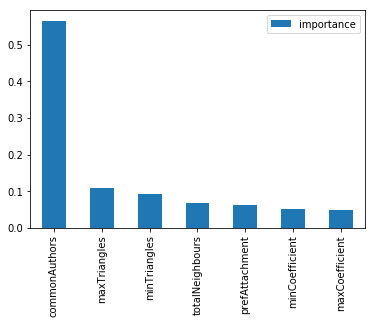

In [478]:
# extract feature importance
feature_importance = pd.DataFrame(rf7_classifier.feature_importances_, index=x_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importance.plot(kind='bar')

commonAuthors remains the most important, but max and min triangles do make a contribution.

## Community Detection
So far we've added features based on connectivity of individual nodes. We also believe that *communities* - like common research communities, institutes, departments, labs, etc - are likely to be relevant to predicting coauthorship. Rather than trying to find the raw data to label communities, we can identify them using unsupervised methods: label propogation and the louvain algorithm.

*Label propagation* is a fast algorithm for finding communities using network structure alone. Every node is initialized with a unique label, the labels are propagated through the network and at each iteration of propagation, each node updates its label to the one that the maximum number of it's neighbors belong to (ties are broken uniformly and randomly). LPA reaches convergence when each node has the majority label of it's neighbors.

The *Louvain method* of community detection is an algorithm for detecting communities in networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities by evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network. It can reval hierarchies in communities at different scales, which can be useful for understanding the global functioning of a network. However, there are some limitations:
-  resolution: For larger networks, the Louvain method doesn’t stop with the "intuitive" communities. Instead, there’s a second pass through the community modification and coarse-graining stages, in which several of the intuitive communities are merged together. 
-  degeneracy: There is typically an exponentially large (in network size) number of community assignments with modularities close to the maximum. This can be a severe problem because, in the presence of a large number of high modularity solutions, it’s hard to find the global maximum, and difficult to determine if the global maximum is truly more scientifically important than local maxima that achieve similar modularity. 

Let's add in community labels from LPA as well as louvain and look at their impact on the model performance.

In [479]:
# add LPA partitions 
query='''
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
  {partitionProperty: "partitionTrain"});
'''
coauthorGraph.run(query);

In [480]:
query='''
CALL algo.labelPropagation("Author", "CO_AUTHOR_LATE", "BOTH",
  {partitionProperty: "partitionTest"});
'''
coauthorGraph.run(query);

In [481]:
# calculate the Louvain clusters: 
query='''
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
'''
coauthorGraph.run(query);

query='''
CALL algo.louvain.stream("Author", "CO_AUTHOR_LATE", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
'''
coauthorGraph.run(query);

In [486]:
def apply_community_features(data, partition_prop, louvain_prop):
    query='''
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN 1 ELSE 0 END AS samePartition,
           CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN 1 ELSE 0 END AS sameLouvain
    '''
    # you have to recast the node IDs as ints bc of a collision with numpy int64
    params = {
        "pairs" : [{"node1":int(row["node1"]), "node2": int(row["node2"])} for index, row in data.iterrows()],    
        "partitionProp": partition_prop,
        "louvainProp": louvain_prop
    }
    result = coauthorGraph.run(query,params).data()
    result = pd.DataFrame(result)
    merged_result = pd.merge(data, result, on=['node1','node2'])
    return merged_result

In [488]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
testing_df = apply_community_features(testing_df,  "partitionTest", "louvainTest")

In [491]:
# I should make plots here to compare LPA and Louvain communities between 
# authors who have and haven't collaborated, but I'm tired, so I'll leave 
# that for tomorrow

In [493]:
# random forest classifier - set up the model inputs and targets
# have to reshape the arrays to work with sklearn
#x_train=training_df['commonAuthors'].values.reshape(-1,1)
x_train=training_df[["commonAuthors", "prefAttachment", "totalNeighbours", "minTriangles", "maxTriangles",
          "minCoefficient", "maxCoefficient", "samePartition", "sameLouvain"]]
x_test11=testing_df[["commonAuthors", "prefAttachment", "totalNeighbours", "minTriangles", "maxTriangles",
          "minCoefficient", "maxCoefficient", "samePartition", "sameLouvain"]]
y_train=training_df['label'].values.reshape(-1,1)
y_test=testing_df['label'].values.reshape(-1,1)

rf11_classifier=RandomForestClassifier(random_state=42)
# use np.ravel to swap the labels from column to row format
rf11_classifier.fit(x_train, np.ravel(y_train))

y_preds11=rf11_classifier.predict(x_test11)
print("accuracy:", accuracy_score(y_test,y_preds11))
print("recall:", recall_score(y_test,y_preds11))
print("precision:", precision_score(y_test,y_preds11))
print("AUC:", roc_auc_score(y_test, y_preds11))

accuracy: 0.9697078027196201
recall: 0.9653032592272826
precision: 0.9738822728819326
AUC: 0.9697078027196201


Our metrics are still improving slightly, so let's plot the ROC curve as well:

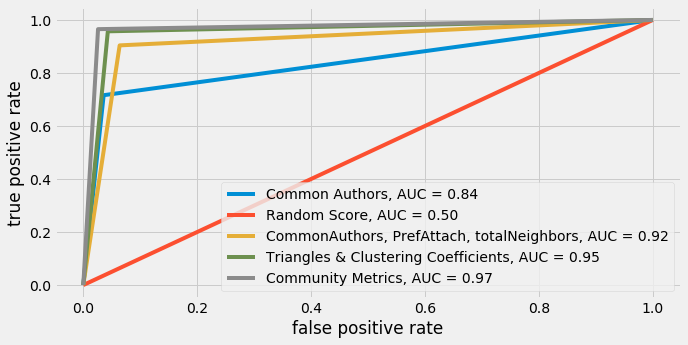

<Figure size 14400x1440 with 0 Axes>

In [494]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_preds3)
fpr7, tpr7, thresholds7 = roc_curve(y_test, y_preds7)
fpr11, tpr11, thresholds11 = roc_curve(y_test, y_preds11)
plt.close()
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Common Authors, AUC = 0.84')
plt.plot([0,1],[0,1], label='Random Score, AUC = 0.50')
plt.plot(fpr3, tpr3, label='CommonAuthors, PrefAttach, totalNeighbors, AUC = 0.92')
plt.plot(fpr7, tpr7, label='Triangles & Clustering Coefficients, AUC = 0.95')
plt.plot(fpr11, tpr11, label='Community Metrics, AUC = 0.97')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="bottom right")
plt.figure(figsize=(200,20))
plt.show()

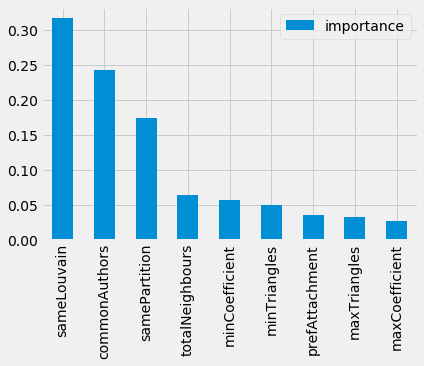

In [495]:
# extract feature importance
feature_importance = pd.DataFrame(rf11_classifier.feature_importances_, index=x_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importance.plot(kind='bar')

What's really interesting here is that for the first time, we see a big shift in variable importance: now belonging to the same Louvain community is the most important variable, followed by common authors and then same partition (another community metric). It looks like community detection algorithms, unsurprisingly, are important predictors of co-authorship.